(bart_heteroscedasticity)=
# Modeling Heteroscedasticity with BART

:::{post} January, 2023
:tags: bart regression 
:category: beginner, reference
:author: [Juan Orduz](https://juanitorduz.github.io/)
:::

In this notebook we show how to use BART to model heteroscedasticity as described in Section 4.1 of [`pymc-bart`](https://github.com/pymc-devs/pymc-bart)'s paper {cite:p}`quiroga2022bart`. We use the `marketing` data set provided by the R package `datarium` {cite:p}`kassambara2019datarium`. The idea is to model a marketing channel contribution to sales as a function of budget.

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

In [2]:
%config InlineBackend.figure_format = "retina"
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
rng = np.random.default_rng(42)

## Read Data

In [3]:
try:
    df = pd.read_csv(os.path.join("..", "data", "marketing.csv"), sep=";", decimal=",")
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("marketing.csv"), sep=";", decimal=",")

n_obs = df.shape[0]

df.head()

,youtube,facebook,newspaper,sales
0,276.12,45.36,83.04,26.52
1,53.40,47.16,54.12,12.48
2,20.64,55.08,83.16,11.16
3,181.80,49.56,70.20,22.20
4,216.96,12.96,70.08,15.48


## EDA

We start by looking into the data. We are going to focus on *Youtube*.

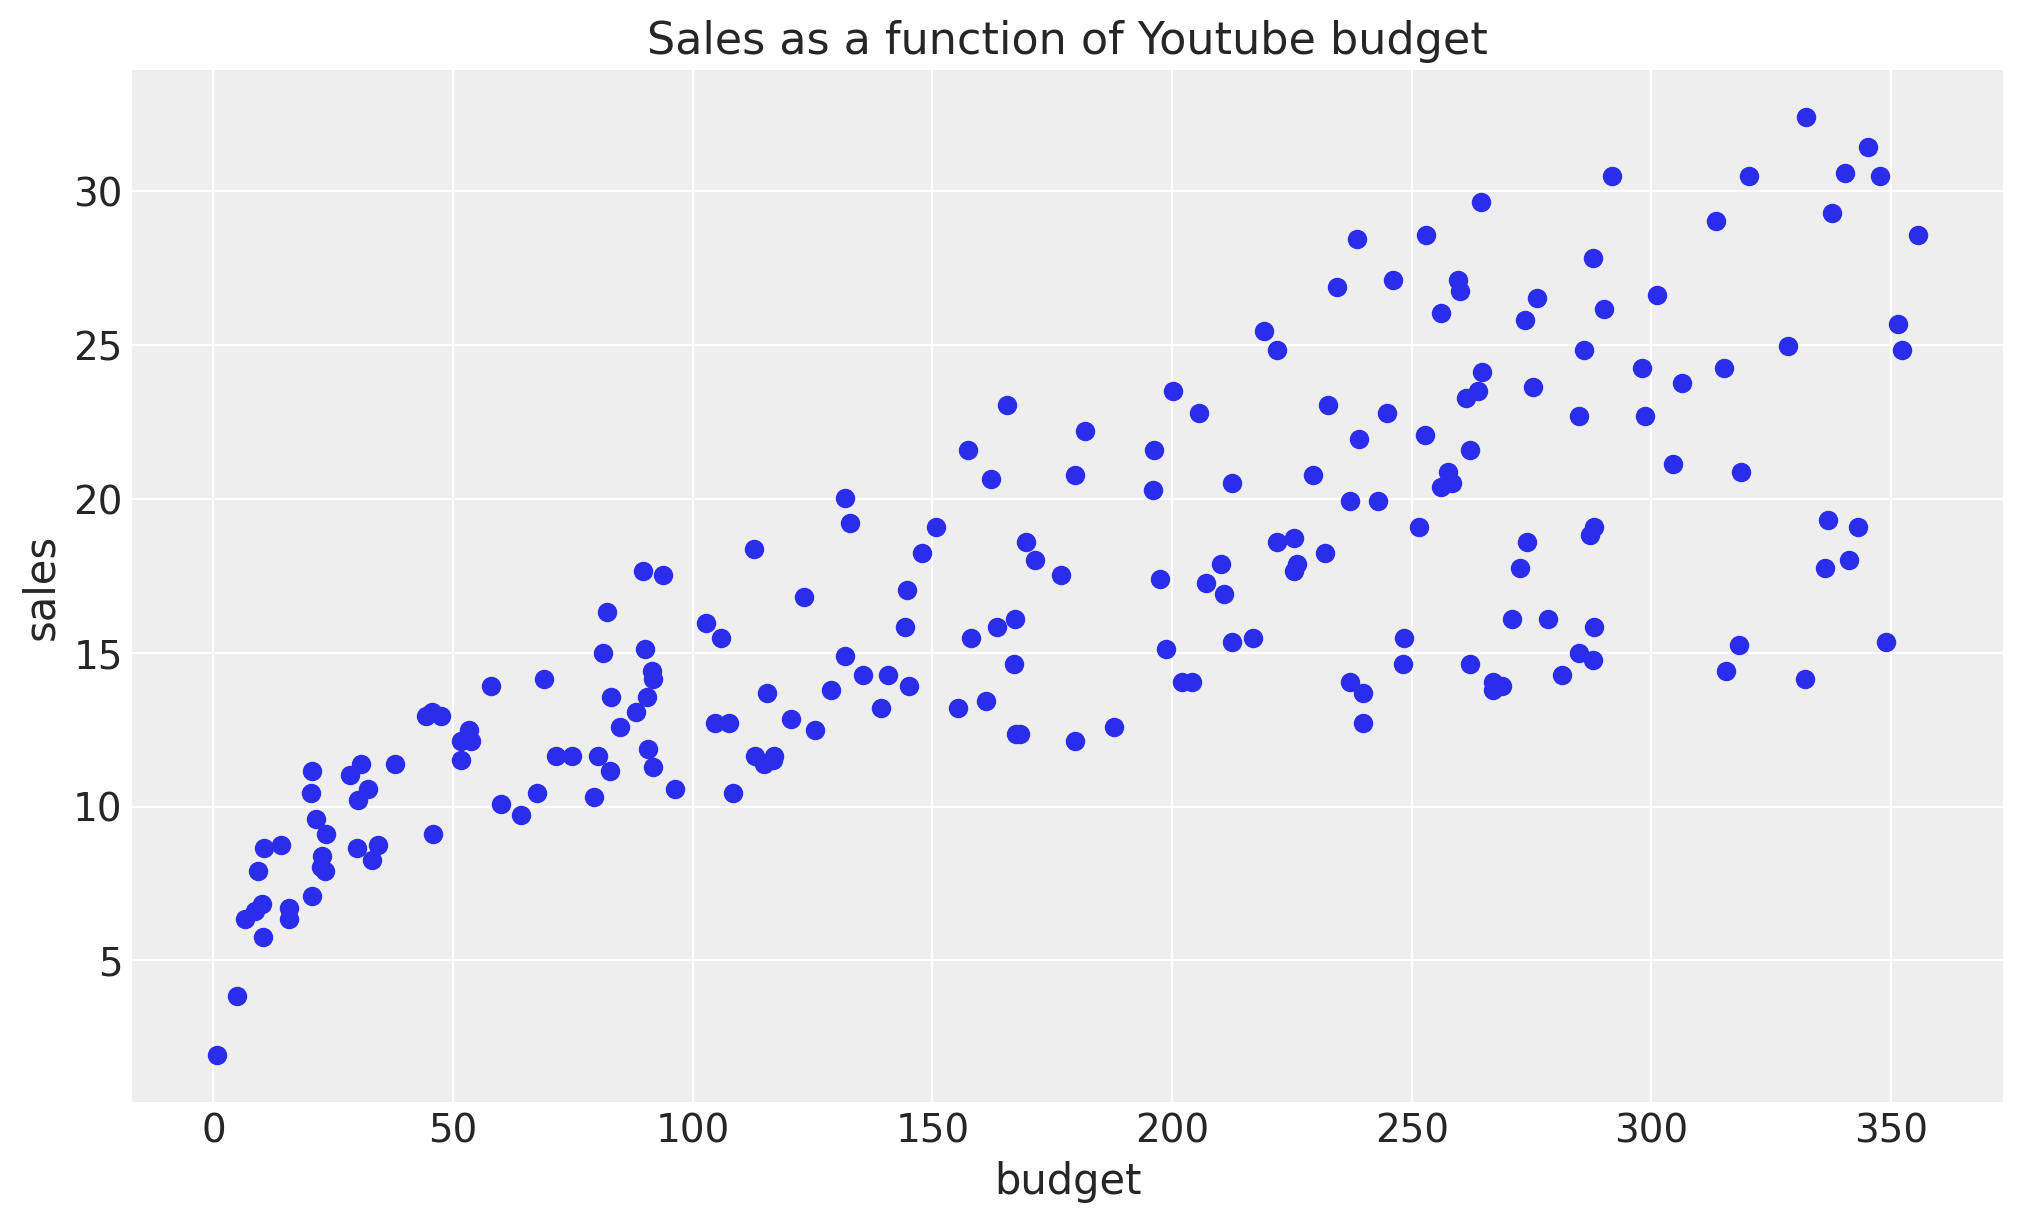

In [4]:
fig, ax = plt.subplots()
ax.plot(df["youtube"], df["sales"], "o", c="C0")
ax.set(title="Sales as a function of Youtube budget", xlabel="budget", ylabel="sales");

We clearly see that both the mean and variance are increasing as a function of budget. One possibility is to manually select and explicit parametrization of these functions, e.g. square root or logarithm. However, in this example we want to learn these functions from the data using a BART model.

## Model Specification

We proceed to prepare the data for modeling. We are going to use the `budget` as the predictor and `sales` as the response.

In [5]:
X = df["youtube"].to_numpy().reshape(-1, 1)
Y = df["sales"].to_numpy()

Next, we specify the model. Note that we just need one BART distribution which can be vectorized to model both the mean and variance. We use a Gamma distribution as likelihood as we expect the sales to be positive.

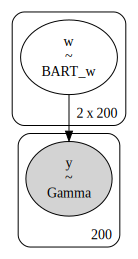

In [6]:
with pm.Model() as model_marketing_full:
    w = pmb.BART(name="w", X=X, Y=Y, m=200, shape=(2, n_obs))
    y = pm.Gamma(name="y", mu=w[0], sigma=pm.math.abs(w[1]), observed=Y)

pm.model_to_graphviz(model=model_marketing_full)

We now fit the model.

In [7]:
with model_marketing_full:
    idata_marketing_full = pm.sample(random_seed=rng)
    posterior_predictive_marketing_full = pm.sample_posterior_predictive(
        trace=idata_marketing_full, random_seed=rng
    )

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 363 seconds.
Sampling: [y]


## Results

We can now visualize the posterior predictive distribution of the mean and the likelihood.

In [8]:
posterior_mean = idata_marketing_full.posterior["w"].mean(dim=("chain", "draw"))[0]

w_hdi = az.hdi(ary=idata_marketing_full, group="posterior", var_names=["w"])

y_hdi = az.hdi(
    ary=posterior_predictive_marketing_full, group="posterior_predictive", var_names=["y"]
)

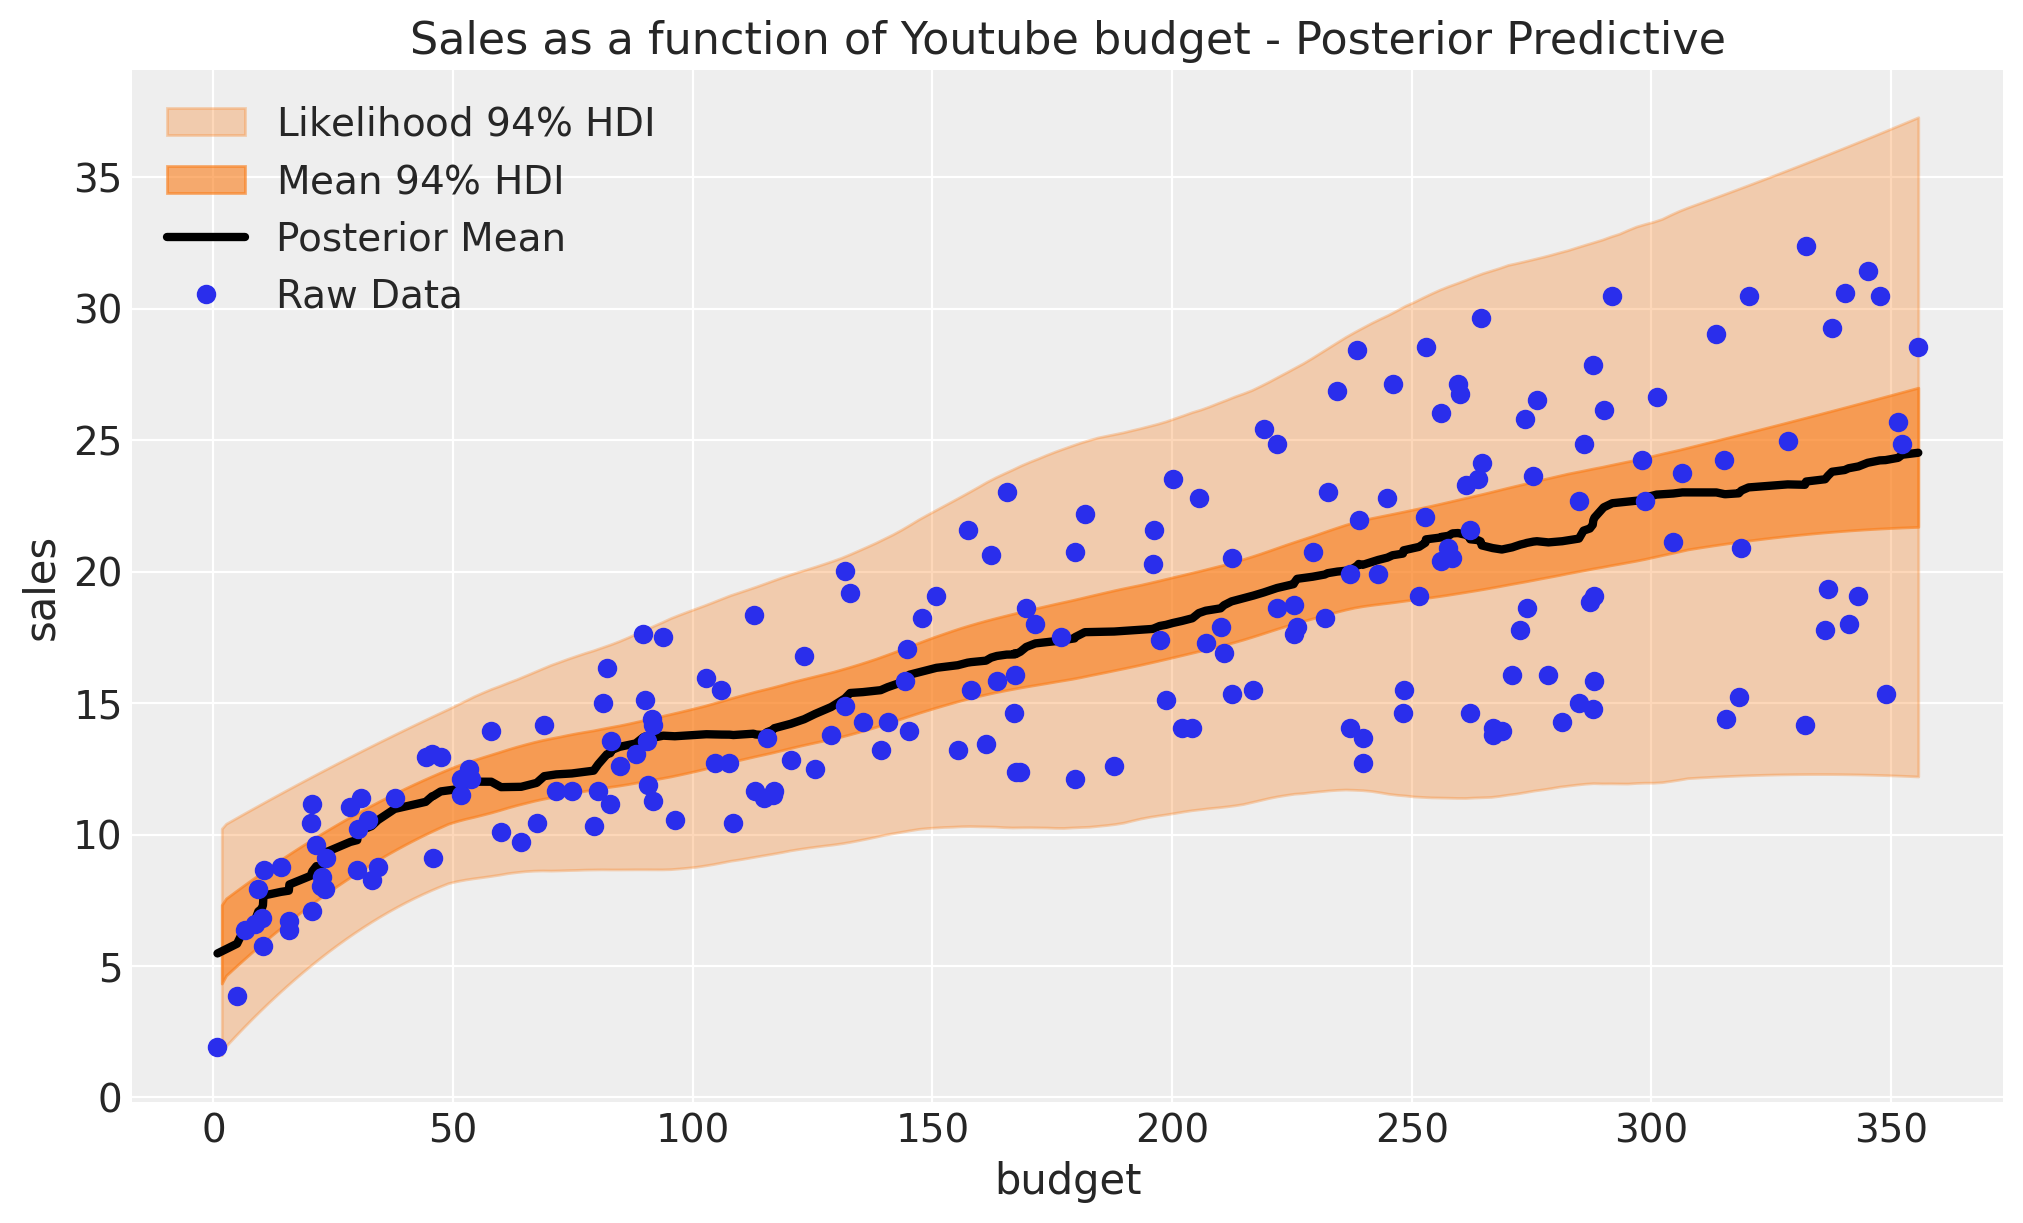

In [9]:
idx = np.argsort(X[:, 0])

fig, ax = plt.subplots()
az.plot_hdi(
    x=X[:, 0], hdi_data=y_hdi, ax=ax, fill_kwargs={"alpha": 0.3, "label": r"Likelihood $94\%$ HDI"}
)
az.plot_hdi(
    x=X[:, 0],
    hdi_data=w_hdi["w"][0, :, :],
    ax=ax,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $94\%$ HDI"},
)
ax.plot(X[:, 0][idx], posterior_mean[idx], c="black", lw=3, label="Posterior Mean")
ax.plot(df["youtube"], df["sales"], "o", c="C0", label="Raw Data")
ax.legend(loc="upper left")
ax.set(
    title="Sales as a function of Youtube budget - Posterior Predictive",
    xlabel="budget",
    ylabel="sales",
);

The fit looks good! We see indeed see the mean and variance increasing as a function of budget.

## Authors
- Authored by [Juan Orduz](https://juanitorduz.github.io/) in February 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Fri Feb 03 2023

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.8.0

pytensor: 2.9.1

sys       : 3.10.9 (main, Jan 11 2023, 09:18:20) [Clang 14.0.6 ]
pandas    : 1.5.3
pymc      : 5.0.2
arviz     : 0.14.0
pymc_bart : 0.3.2
numpy     : 1.23.5
matplotlib: 3.5.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::